### Ingest Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report 
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDClassifier
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_bank = pd.read_csv('https://raw.githubusercontent.com/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/main/company_bankruptcy.csv')

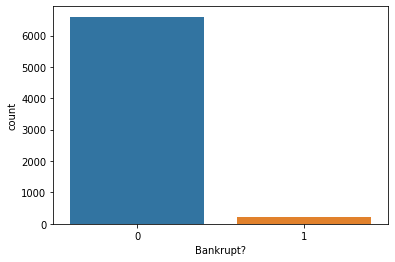

In [3]:
sns.countplot(x='Bankrupt?', data=df_bank)

In [4]:
df_bank['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

Due to this dataset being highly skewed, I am going to use SMOTE to even out the classes. SMOTE will oversample the minority class by synthesizing new examples based on the examples already provided. It will randomly select example and then assess k of the nearest neighbors for that example. Then a randomly selected neighbor will be chosen till the process has produced even classes. A downside to this approach is that the examples are being created without considering the majority class which could result in ambiguous examples. Most likely in the real world, this dataset would require additional data, a new business question be asked, or start from scratch. 

### Resampling using SMOTE

In [5]:
y = df_bank['Bankrupt?']
x = df_bank.drop('Bankrupt?', axis=1)

In [6]:
scaler = StandardScaler()
x = scaler.fit_transform(x.astype(np.float64))

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 42)

In [8]:
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

Below we will oversample the minority class to have more examples than the majority as well as randomly undersample the majority class. Being able to oversample the minority class will help improve bias towards those examples while undersampling the majority class will decrease the bias to those examples. 

In [9]:
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [10]:
x_train_sm, y_train_sm = pipeline.fit_resample(x_train, y_train)

### Models

#### SMV no kernal

accuracy score =  0.9010263929618768
Classification Report               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1313
           1       0.22      0.65      0.33        51

    accuracy                           0.90      1364
   macro avg       0.60      0.78      0.64      1364
weighted avg       0.96      0.90      0.92      1364



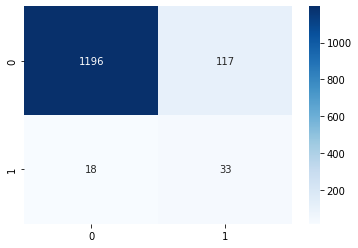

In [11]:
svc = SVC()
svc.fit(x_train_sm, y_train_sm)

sy_pred = svc.predict(x_test)
cm = confusion_matrix(y_test, sy_pred)

sva = accuracy_score(y_test, sy_pred)
print('accuracy score = ',accuracy_score(y_test, sy_pred))
print("Classification Report",classification_report(y_test, sy_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

#### Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression accuracy is : 0.8958944281524927
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1313
           1       0.22      0.71      0.34        51

    accuracy                           0.90      1364
   macro avg       0.60      0.80      0.64      1364
weighted avg       0.96      0.90      0.92      1364



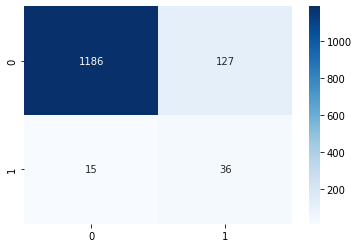

In [12]:
lr_model = LogisticRegression()
lr_model.fit(x_train_sm,y_train_sm)
accuracy_lr = lr_model.score(x_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)
ly_pred= lr_model.predict(x_test)
report = classification_report(y_test,ly_pred)
print("-"*100)
print(report)
cm = confusion_matrix(y_test,lr_model.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

#### Naive Bayes

accuracy score =  0.22947214076246333
Report:               precision    recall  f1-score   support

           0       0.98      0.20      0.34      1313
           1       0.04      0.90      0.08        51

    accuracy                           0.23      1364
   macro avg       0.51      0.55      0.21      1364
weighted avg       0.95      0.23      0.33      1364



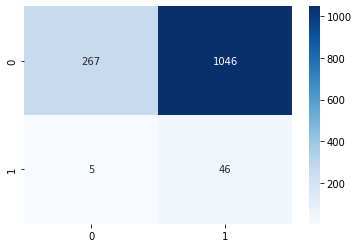

In [13]:
nb = GaussianNB()
nb.fit(x_train_sm,y_train_sm)

ny_pred = nb.predict(x_test)
cm = confusion_matrix(y_test,ny_pred)

nba = accuracy_score(y_test, ny_pred)
print('accuracy score = ', accuracy_score(y_test, ny_pred))
print("Report:", classification_report(y_test, ny_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

### Conclusions

Text(0.5, 1.0, 'Plotting the Model Accuracies')

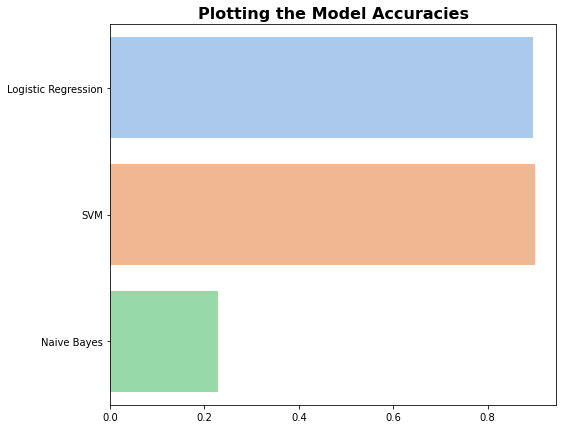

In [14]:
plt.figure(figsize= (8,7))
ac = [accuracy_lr,sva,nba]
name = ['Logistic Regression','SVM','Naive Bayes']
sns.barplot(x = ac,y = name,palette='pastel')
plt.title("Plotting the Model Accuracies", fontsize=16, fontweight="bold")

After using SMOTE versus taking a sample of the original data (in my other notebook) there is almost a small change in accuracy for the LR and SVM models. There was however, an increase in both precision and recall F1 scores for both the LR and SVM.  Just using overfitting of the minority class could cause an increase in all model accuracy but this could allow for overgeneralizing and augmenting noisy regions, which could decrease the individual accuracy of predicting each class.

This resampling was also performed by scaling the features due to the above models having assumptions about normalized data. Without scaling the features, the accuracy decreases significantly. 

The Naive Bayes model accuracy dropped significantly, this could be due to the nature of the model itself. My theory for this is because the probabilities of the classes are being affected by SMOTE and Naive Bayes relies heavily on looking at probabilities. 